# **Task 1: Implementation of a CNN in PyTorch for MNIST Classification**

**Step 1: Load Packages and Import Required Libraries**

In [ ]:
import torch  # PyTorch library
import torch.nn as nn  # Neural network module
import torch.optim as optim  # Optimization algorithms
import torch.nn.functional as F  # Activation functions
from torch.utils.data import DataLoader, TensorDataset, random_split  # Data loading utilities
from torchvision import datasets, transforms  # Datasets and transformations
import matplotlib.pyplot as plt  # Visualization library

**Step 2: Load the Dataset into the Google Colab & Data Preprocessing**

In [ ]:
# Check if GPU (CUDA) is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data transformation: Convert images to tensors and normalize them
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image from [0, 255] range to [0.0, 1.0]
    transforms.Normalize((0.5,), (0.5,))  # Normalize: mean=0.5, std=0.5
])

# Define batch size for training
BATCH_SIZE = 64

# Download and load the MNIST dataset (train & test)
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Split training dataset into training (80%) and validation (20%) sets
train_size = int(0.8 * len(train_dataset))  # 80% for training
val_size = len(train_dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])  # Randomly split data

# Create data loaders for training, validation, and testing
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.07MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.87MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



**Step 3: Print Information to Understand the MNIST Dataset**

Training Dataset Length: 48000
Validation Dataset Length: 12000
Test Dataset Length: 10000
Training Dataset Samples:


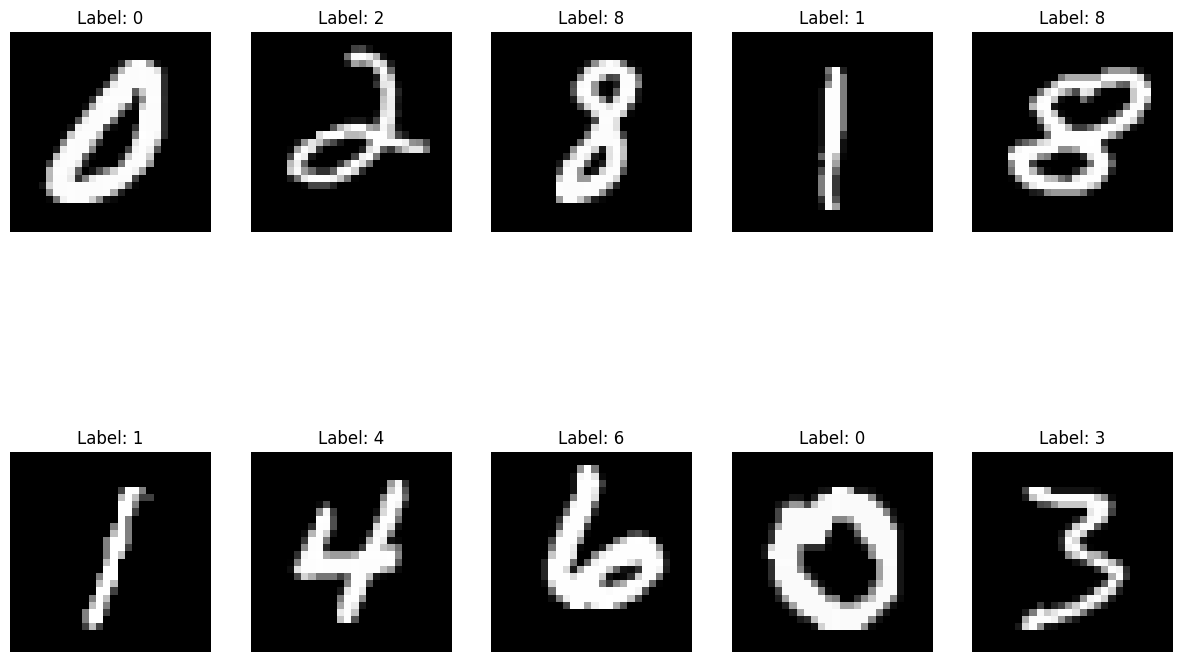

Validation Dataset Samples:


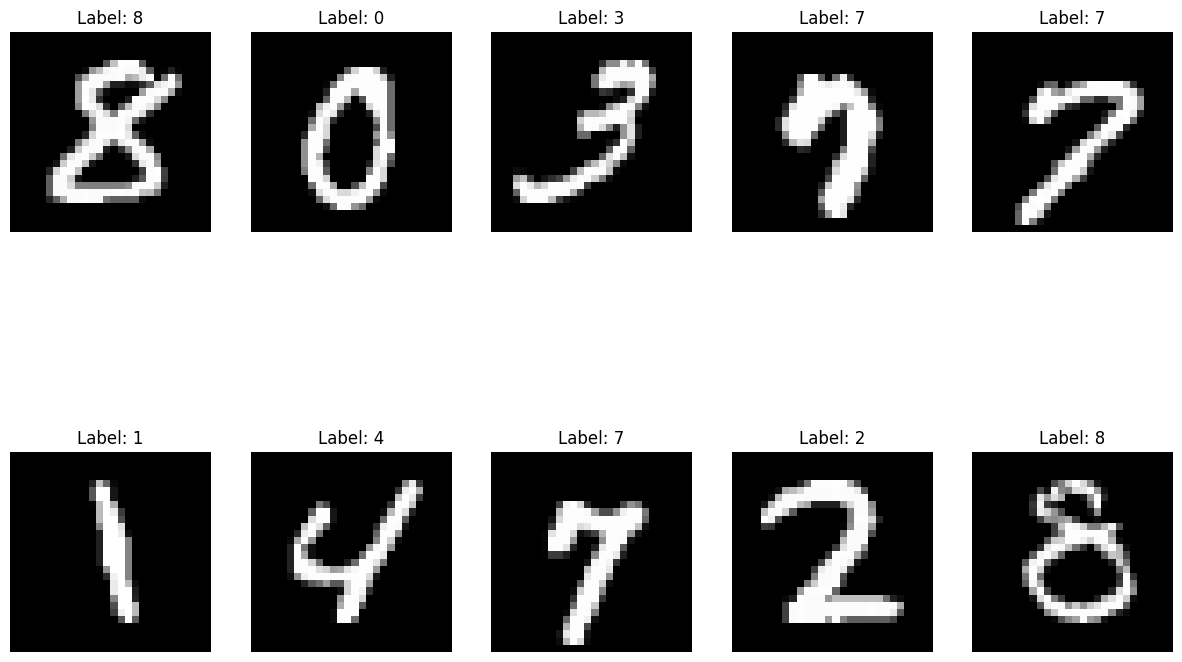

Test Dataset Samples:


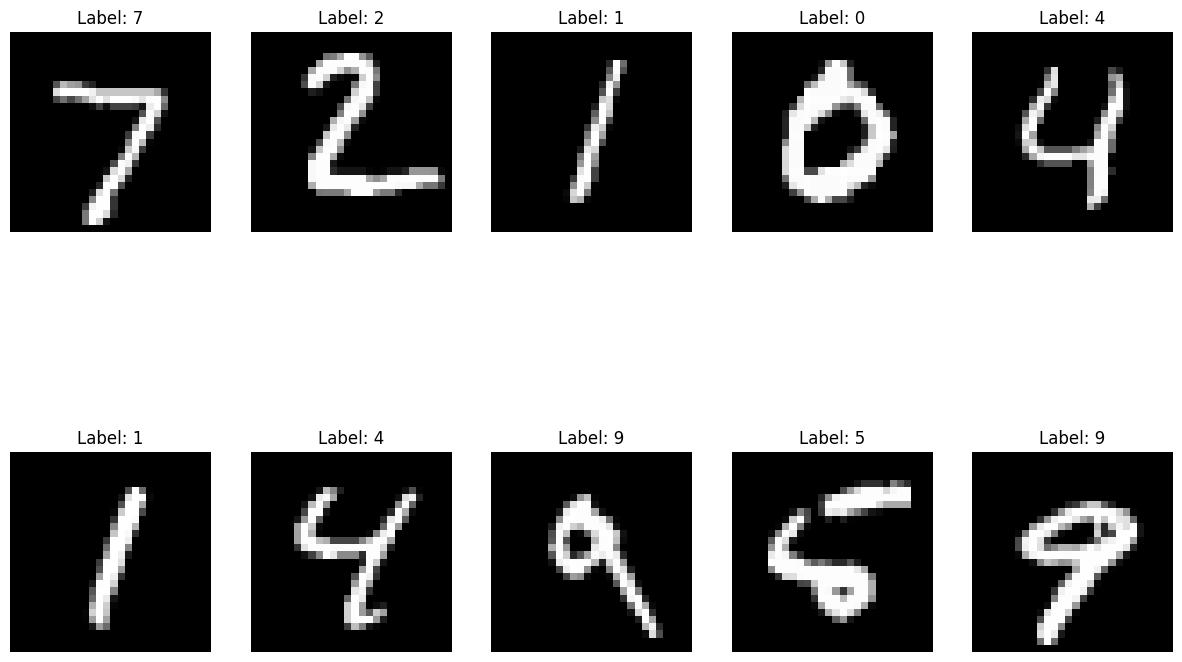

In [ ]:
# Print dataset sizes
print(f"Training Dataset Length: {len(train_dataset)}")
print(f"Validation Dataset Length: {len(val_dataset)}")
print(f"Test Dataset Length: {len(test_dataset)}")

# Function to visualize a few images from the dataset
# Print 10 samples in each dataset and their corresponding labels
def show_images_and_labels(dataset, num_images=10):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        image, label = dataset[i]  # Get image and label
        plt.subplot(2, 5, i + 1)  # Arrange images in 2 rows, 5 columns
        plt.imshow(image.squeeze(), cmap="gray")  # Show grayscale image
        plt.title(f"Label: {label}")  # Display corresponding label
        plt.axis('off')  # Hide axis lines
    plt.show()

# Display samples from datasets
print("Training Dataset Samples:")
show_images_and_labels(train_dataset)

print("Validation Dataset Samples:")
show_images_and_labels(val_dataset)

print("Test Dataset Samples:")
show_images_and_labels(test_dataset)

**Step 4: Define CNN Model**

In [ ]:
# Define a CNN Model for MNIST classification
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # First convolutional layer: Input (1 channel), Output (32 channels), Kernel size 3x3
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling layer (2x2)
        # Second convolutional layer: Input (32 channels), Output (64 channels)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Flattened input to 128 neurons
        self.dropout = nn.Dropout(0.2)  # Dropout layer (prevents overfitting)
        self.fc2 = nn.Linear(128, 64)  # Fully connected layer (64 neurons)
        self.fc3 = nn.Linear(64, 10)  # Output layer (10 classes for digits 0-9)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Conv1 -> ReLU -> MaxPool
        x = self.pool(F.relu(self.conv2(x)))  # Conv2 -> ReLU -> MaxPool
        x = x.view(-1, 64 * 7 * 7)  # Flatten the output for the fully connected layer
        x = F.relu(self.fc1(x))  # Fully connected layer with ReLU
        x = self.dropout(x)  # Apply dropout
        x = F.relu(self.fc2(x))  # Second fully connected layer with ReLU
        x = self.fc3(x)  # Output layer (no activation, raw scores)
        return x

**Step 5: Instantiate our CNN Model and Train the Model**

In [ ]:
# Create CNN model instance and move it to the selected device (CPU/GPU)
model = CNN().to(device)

# Define optimizer (Adam) and loss function (CrossEntropy)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, val_loader, optimizer, num_epochs, model_save_path):
    best_val_loss = float('inf')  # Track lowest validation loss
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        train_loss = 0.0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)  # Move data to device
            optimizer.zero_grad()  # Reset gradients
            output = model(data)  # Forward pass
            loss = F.cross_entropy(output, target)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights
            train_loss += loss.item()  # Accumulate training loss

        # Validation step
        val_loss = 0.0
        correct = 0
        total = 0
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = F.cross_entropy(output, target)
                val_loss += loss.item()

                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
                total += target.size(0)

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct / total

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        # Save the best model based on validation loss
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_save_path)
            print(f"Model saved at Epoch {epoch+1}")

# Train the model for 10 epochs and save the best model
model_save_path = 'best_model.pth'
train_model(model, train_loader, val_loader, optimizer, num_epochs=10, model_save_path=model_save_path)

Epoch 1/10, Training Loss: 0.2390, Validation Loss: 0.0654, Validation Accuracy: 0.9805
Model saved at Epoch 1
Epoch 2/10, Training Loss: 0.0659, Validation Loss: 0.0524, Validation Accuracy: 0.9852
Model saved at Epoch 2
Epoch 3/10, Training Loss: 0.0505, Validation Loss: 0.0445, Validation Accuracy: 0.9860
Model saved at Epoch 3
Epoch 4/10, Training Loss: 0.0403, Validation Loss: 0.0435, Validation Accuracy: 0.9883
Model saved at Epoch 4
Epoch 5/10, Training Loss: 0.0307, Validation Loss: 0.0420, Validation Accuracy: 0.9885
Model saved at Epoch 5
Epoch 6/10, Training Loss: 0.0269, Validation Loss: 0.0421, Validation Accuracy: 0.9893
Epoch 7/10, Training Loss: 0.0212, Validation Loss: 0.0414, Validation Accuracy: 0.9884
Model saved at Epoch 7
Epoch 8/10, Training Loss: 0.0197, Validation Loss: 0.0463, Validation Accuracy: 0.9884
Epoch 9/10, Training Loss: 0.0178, Validation Loss: 0.0426, Validation Accuracy: 0.9894
Epoch 10/10, Training Loss: 0.0148, Validation Loss: 0.0555, Validatio

**Step 6: Evaluate the Trained Model on Testing Dataset**

In [ ]:
# Function to test the trained model on the test dataset
def test_model(model, test_loader, num_samples=100):
    model.eval()  # Set model to evaluation mode (no weight updates)
    test_loss = 0.0
    correct = 0
    sample_count = 0  # To track how many sample predictions are printed

    with torch.no_grad():  # Disable gradient calculation for efficiency
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)  # Move data to GPU/CPU
            output = model(data)  # Forward pass
            test_loss += F.cross_entropy(output, target).item()  # Compute loss
            pred = output.argmax(dim=1, keepdim=True)  # Get predicted class index
            correct += pred.eq(target.view_as(pred)).sum().item()  # Count correct predictions

            # Print a few sample predictions (up to 'num_samples')
            if sample_count < num_samples:
                print("\nSample predictions:")
                for i in range(data.size(0)):  # Iterate through batch
                    if sample_count >= num_samples:
                        break  # Stop if we've printed enough samples
                    print(f"Sample {sample_count + 1}:")
                    print(f"  True label: {target[i].item()}")
                    print(f"  Predicted raw output: {output[i]}")
                    print(f"  Predicted label: {pred[i].item()}")
                    sample_count += 1

    # Compute average test loss and accuracy
    avg_test_loss = test_loss / len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)

    # Print final results
    print(f"\nTest Loss: {avg_test_loss:.4f}, Accuracy: {accuracy:.4f}")

# Function to load a saved model and evaluate it on the test dataset
def load_and_test_model(model, model_load_path, test_loader):
    model.load_state_dict(torch.load(model_load_path))  # Load trained model weights
    model.to(device)  # Move model to GPU/CPU
    test_model(model, test_loader)  # Run testing function

# Define device (CPU/GPU) again for consistency
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create a new instance of the CNN model and move it to the device
model = CNN().to(device)

# Path to the best saved model
model_load_path = 'best_model.pth'

# Load the saved model and evaluate it on the test set
load_and_test_model(model, model_load_path, test_loader)


<ipython-input-6-b1fefecd0347>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_load_path))  # Load trained model weights



Sample predictions:
Sample 1:
  True label: 7
  Predicted raw output: tensor([ -9.5087,   0.2191,   0.7130,   0.2889,  -6.5790,  -8.0905, -12.1568,
         18.5136,  -7.4496,   0.4841], device='cuda:0')
  Predicted label: 7
Sample 2:
  True label: 2
  Predicted raw output: tensor([ -3.3884,  -3.0814,  19.0802,  -8.0536,  -7.1094, -12.9040,  -3.8338,
         -8.8126,  -4.2844, -16.8064], device='cuda:0')
  Predicted label: 2
Sample 3:
  True label: 1
  Predicted raw output: tensor([-8.1115, 13.4394, -5.4307, -8.4320, -3.4044, -5.7032, -5.4196,  2.5219,
        -6.4794, -3.2176], device='cuda:0')
  Predicted label: 1
Sample 4:
  True label: 0
  Predicted raw output: tensor([11.4493, -3.7902, -1.4933, -3.3048, -6.2717, -3.9064, -1.6127, -3.8206,
        -2.4156, -2.9158], device='cuda:0')
  Predicted label: 0
Sample 5:
  True label: 4
  Predicted raw output: tensor([-9.5892,  0.4175, -7.6183, -9.3817, 15.9134, -7.5445, -4.6146, -1.4244,
        -3.5455,  6.1785], device='cuda:0')
  Pre

# **Task 2: Add Gaussian Noises**

**Step 1: Define the Function & Apply Noise to the Dataset**

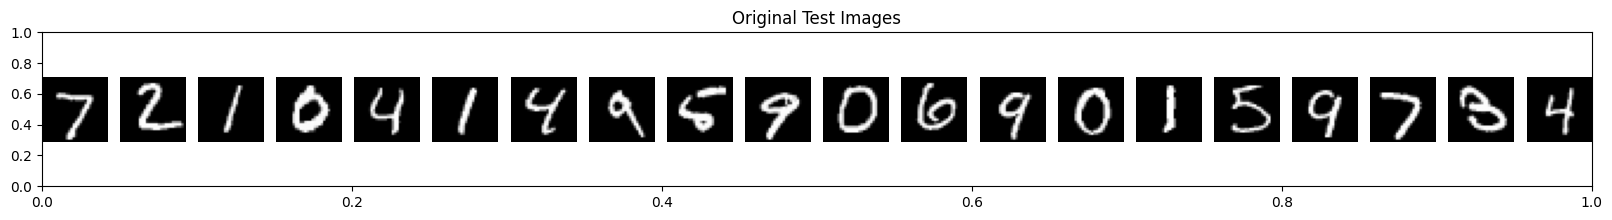

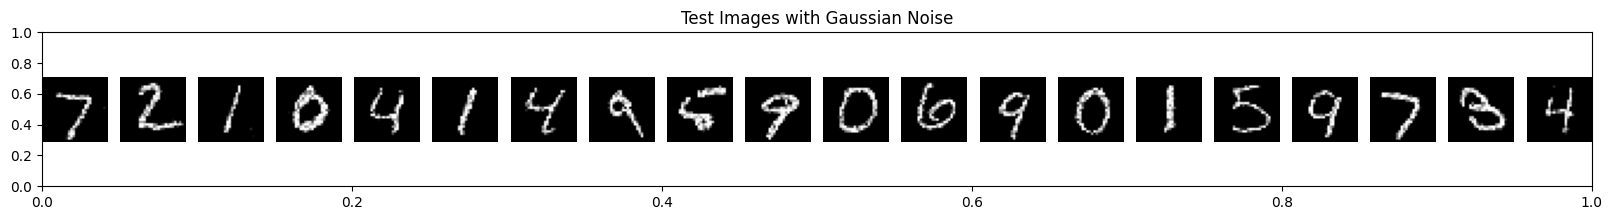

In [ ]:
# Function to add Gaussian noise to an image
def add_gaussian_noise(img, mean=0., std=0.1):
    """
    Adds Gaussian noise to a given image.

    Parameters:
        img (Tensor): Input image tensor.
        mean (float): Mean of the Gaussian noise.
        std (float): Standard deviation (amount of noise added).

    Returns:
        Tensor: Noisy image tensor, clamped to [0,1] range to keep valid pixel values.
    """
    noise = torch.randn(img.size()) * std + mean  # Generate Gaussian noise
    noisy_img = img + noise  # Add noise to the image
    return noisy_img.clamp(0, 1)  # Clamp values to keep them between [0,1]

# Define transformation pipeline with Gaussian noise
transform_with_noise = transforms.Compose([
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize((0.5,), (0.5,)),  # Normalize image (mean=0.5, std=0.5)
    transforms.Lambda(lambda x: add_gaussian_noise(x, std=0.3))  # Apply Gaussian noise (std = 0.3)
])

# Load the MNIST test dataset with Gaussian noise applied
test_dataset_with_noise = datasets.MNIST(
    root='./data', train=False, transform=transform_with_noise, download=True
)

# Create DataLoader for noisy test dataset
test_loader_with_noise = DataLoader(test_dataset_with_noise, batch_size=BATCH_SIZE, shuffle=False)

# Function to display images with or without noise
def show_images(dataset, idxs, title):
    """
    Displays a set of images from the dataset.

    Parameters:
        dataset: The dataset containing images.
        idxs (list): Indices of images to display.
        title (str): Title of the plot.
    """
    plt.figure(figsize=(20, 2))  # Set figure size
    plt.title(title)  # Set title
    for i, idx in enumerate(idxs):  # Loop through selected images
        ax = plt.subplot(1, len(idxs), i + 1)  # Create subplot
        plt.imshow(dataset[idx][0].squeeze(), cmap='gray')  # Display image in grayscale
        plt.axis('off')  # Remove axis
    plt.show()  # Show images

# Select first 20 images for visualization
idxs = range(20)

# Show original test images (without noise)
show_images(test_dataset, idxs, "Original Test Images")

# Show test images with Gaussian noise
show_images(test_dataset_with_noise, idxs, "Test Images with Gaussian Noise")


**Step 2: Evaluate the Model on Noisy Data**

In [ ]:
print("Testing on noisy data:")
test_model(model, test_loader_with_noise)

Testing on noisy data:

Sample predictions:
Sample 1:
  True label: 7
  Predicted raw output: tensor([-2.8814, -1.8039,  1.8662,  2.9740, -4.3621, -2.1989, -3.9904,  5.9482,
         0.4471, -2.0342], device='cuda:0')
  Predicted label: 7
Sample 2:
  True label: 2
  Predicted raw output: tensor([-0.0250, -4.8660,  6.9218, -1.6944, -5.9919, -3.4720, -0.5409, -6.9349,
         5.1325, -6.7383], device='cuda:0')
  Predicted label: 2
Sample 3:
  True label: 1
  Predicted raw output: tensor([-3.4952, -0.1081, -0.6732,  1.0179, -2.6740, -0.1955, -2.1005,  0.8739,
         2.4500, -1.9126], device='cuda:0')
  Predicted label: 8
Sample 4:
  True label: 0
  Predicted raw output: tensor([ 4.2461, -3.7668,  0.5812, -0.6252, -3.9943, -1.5402,  0.5004, -3.7124,
        -0.3622, -2.0959], device='cuda:0')
  Predicted label: 0
Sample 5:
  True label: 4
  Predicted raw output: tensor([-3.7716, -0.2585, -3.1098, -3.9508,  5.3671, -1.8267, -1.0140, -1.6025,
         1.6444,  1.0622], device='cuda:0')
  

# **Task 3: Add FGSM (Fast Gradient Sign Method) Noises**

**Step 1: Define the Function and Appply Noise to the Dataset**

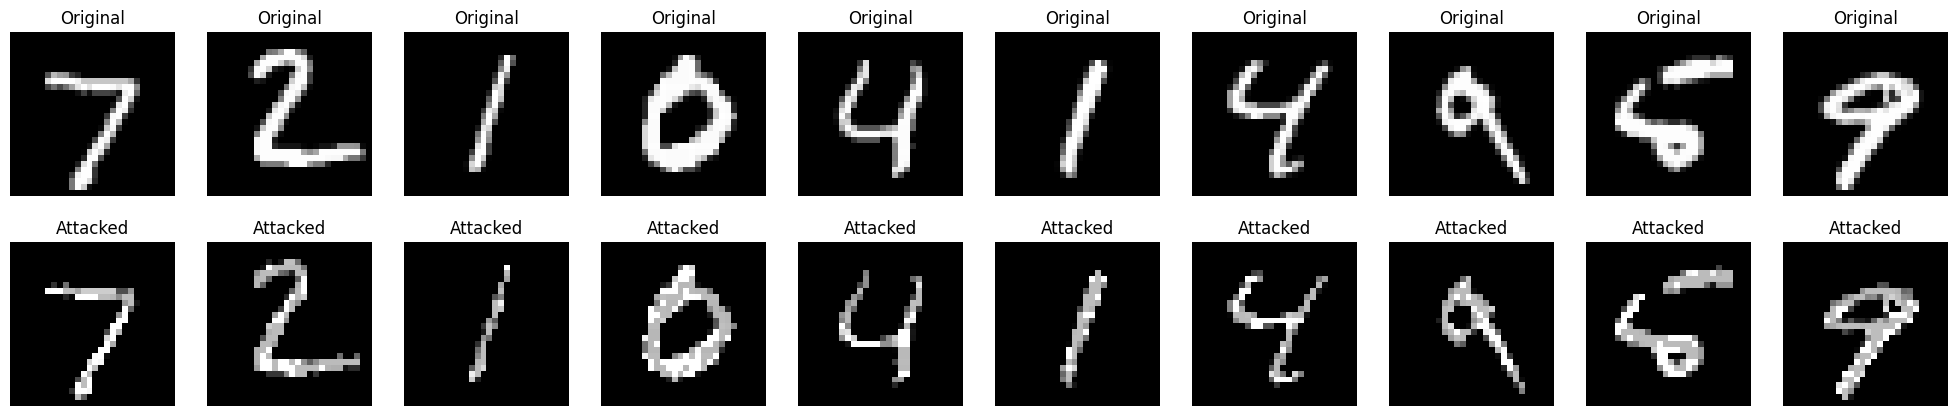

In [ ]:
# Import necessary libraries
import torch  # PyTorch library
import torch.nn.functional as F  # PyTorch functions (e.g., cross-entropy loss)
import matplotlib.pyplot as plt  # For visualization
from torchvision import datasets, transforms  # PyTorch datasets and transformations
from torch.utils.data import DataLoader  # Data loading utilities

# Function to apply FGSM attack
def fgsm_attack(image, epsilon, data_grad):
    """
    Generates an adversarial example using the Fast Gradient Sign Method (FGSM).

    Parameters:
        image (Tensor): The original input image.
        epsilon (float): The attack strength (higher = more distortion).
        data_grad (Tensor): The gradient of the loss w.r.t. the input image.

    Returns:
        Tensor: The perturbed adversarial image, clamped between [0,1] to keep valid pixel values.
    """
    sign_data_grad = data_grad.sign()  # Get the sign of the gradient
    perturbed_image = image + epsilon * sign_data_grad  # Add perturbation to the image
    perturbed_image = torch.clamp(perturbed_image, 0, 1)  # Ensure values stay in valid range
    return perturbed_image

# Function to apply FGSM attack on the entire test dataset
def test_fgsm_attack(model, device, test_loader, epsilon):
    """
    Generates adversarial examples for all images in the test dataset using FGSM.

    Parameters:
        model (nn.Module): The trained CNN model.
        device (torch.device): The device (CPU or GPU) to use.
        test_loader (DataLoader): DataLoader for the test dataset.
        epsilon (float): The attack strength.

    Returns:
        list: A list of adversarial images.
    """
    model.eval()  # Set model to evaluation mode (no training)
    attacked_images = []  # List to store adversarial images

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)  # Move data to GPU/CPU
        data.requires_grad = True  # Enable gradient computation for FGSM attack

        output = model(data)  # Forward pass
        loss = F.cross_entropy(output, target)  # Compute loss
        model.zero_grad()  # Reset gradients
        loss.backward()  # Compute gradients w.r.t. input image
        data_grad = data.grad.data  # Get gradient values

        perturbed_data = fgsm_attack(data, epsilon, data_grad)  # Generate adversarial image
        attacked_images.extend(perturbed_data.detach().cpu())  # Store images in list (convert to CPU first)

    return attacked_images  # Return adversarial images

# Function to display original and attacked images side-by-side
def show_images(image_list1, image_list2, title1, title2, num_images=10):
    """
    Displays a set of original and adversarial images side-by-side for comparison.

    Parameters:
        image_list1 (list): List of original images.
        image_list2 (list): List of adversarial (FGSM-attacked) images.
        title1 (str): Title for the original images.
        title2 (str): Title for the adversarial images.
        num_images (int): Number of images to display.
    """
    plt.figure(figsize=(25, 5))  # Set figure size
    for i in range(num_images):  # Loop through selected images
        plt.subplot(2, num_images, i+1)  # Create subplot (row 1: original)
        plt.imshow(image_list1[i].squeeze(), cmap='gray')  # Display original image
        plt.title(title1)  # Set title
        plt.axis('off')  # Remove axis

        plt.subplot(2, num_images, num_images+i+1)  # Create subplot (row 2: adversarial)
        plt.imshow(image_list2[i].squeeze(), cmap='gray')  # Display attacked image
        plt.title(title2)  # Set title
        plt.axis('off')  # Remove axis

    plt.show()  # Show images

# Define attack strength (epsilon)
epsilon = 0.25  # Adjust to increase/decrease attack severity

# Generate FGSM-attacked images
attacked_images = test_fgsm_attack(model, device, test_loader, epsilon)

# Select first 10 images for visualization
num_images = 10
original_test_images = [test_dataset[i][0] for i in range(num_images)]  # Extract original images

# Show original vs. FGSM-attacked images
show_images(original_test_images, attacked_images, "Original", "Attacked", num_images)


**Step 2: Evaluate the Model on Attacked Data**

In [ ]:
# Import TensorDataset (to create dataset from adversarial images)
from torch.utils.data import TensorDataset

# Function to test the CNN model on FGSM-attacked images
def test_model_on_attacked(model, attacked_loader, num_samples=100):
    """
    Evaluates the CNN model on adversarial (FGSM-attacked) images.

    Parameters:
        model (nn.Module): The trained CNN model.
        attacked_loader (DataLoader): DataLoader for the adversarial dataset.
        num_samples (int): Number of samples to print with detailed output.

    Prints:
        - Sample predictions (up to `num_samples`).
        - Accuracy on first `num_samples` images.
        - Overall accuracy on the entire attacked dataset.
    """
    model.eval()  # Set model to evaluation mode (no gradient updates)
    correct = 0  # Track correct predictions
    total = 0  # Track total images
    detailed_sample_count = 0  # Track number of printed samples

    with torch.no_grad():  # Disable gradient calculations for efficiency
        for data, target in attacked_loader:
            data, target = data.to(device), target.to(device)  # Move data to GPU/CPU
            output = model(data)  # Forward pass
            pred = output.argmax(dim=1, keepdim=True)  # Get predicted class
            correct_preds = pred.eq(target.view_as(pred))  # Check correct predictions

            # Print sample predictions (up to `num_samples`)
            for idx in range(data.size(0)):
                if detailed_sample_count < num_samples:
                    print(f"Sample {detailed_sample_count + 1}:")
                    print(f"  True label: {target[idx].item()}")
                    print(f"  Predicted raw output: {output[idx]}")  # Print logits
                    print(f"  Predicted label: {pred[idx].item()}")
                    detailed_sample_count += 1  # Increment sample counter

                correct += correct_preds[idx].item()  # Count correct predictions
                total += 1  # Increment total images processed

    # Compute accuracy
    accuracy = correct / total

    # Print results
    print(f"\nAccuracy on first {num_samples} attacked images: {accuracy:.2f}")
    print(f"Overall accuracy on attacked dataset: {correct / total:.2f}")

# Convert FGSM-attacked images into a dataset
attacked_data = torch.stack(attacked_images)  # Convert list of tensors into a batch
attacked_targets = torch.tensor(test_dataset.targets[:len(attacked_images)])  # Get corresponding labels
attacked_dataset = TensorDataset(attacked_data, attacked_targets)  # Create dataset

# Create DataLoader for adversarial dataset
attacked_loader = DataLoader(attacked_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Evaluate model on FGSM-attacked images
test_model_on_attacked(model, attacked_loader, num_samples=100)


<ipython-input-12-39c7cf723d8d>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attacked_targets = torch.tensor(test_dataset.targets[:len(attacked_images)])  # Get corresponding labels


Sample 1:
  True label: 7
  Predicted raw output: tensor([-3.1437, -1.8216,  1.8547,  3.3803, -4.8337, -2.5385, -4.6039,  6.6556,
         0.0147, -1.9668], device='cuda:0')
  Predicted label: 7
Sample 2:
  True label: 2
  Predicted raw output: tensor([ 0.4242, -4.0038,  4.5913, -0.8018, -4.9647, -2.5534,  0.3307, -5.9319,
         3.4842, -4.9928], device='cuda:0')
  Predicted label: 2
Sample 3:
  True label: 1
  Predicted raw output: tensor([-2.8253, -0.2499, -0.3472,  1.2176, -2.4471, -0.0289, -1.8063,  0.6328,
         1.8495, -1.6554], device='cuda:0')
  Predicted label: 8
Sample 4:
  True label: 0
  Predicted raw output: tensor([ 1.9346, -1.9273,  0.2729,  1.0523, -4.3021, -0.6343,  0.3298, -2.6803,
        -1.2165, -2.8641], device='cuda:0')
  Predicted label: 0
Sample 5:
  True label: 4
  Predicted raw output: tensor([-2.8876, -1.8236, -2.7493, -2.9724,  3.7729, -1.3205, -1.7688, -2.2404,
         1.8339,  2.6249], device='cuda:0')
  Predicted label: 4
Sample 6:
  True label: 1

# **Task 4: Implement Countermeasure**

## **Approach 1: Adversarial Training**

**Step 1: Import Required Libraries**

In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


**Step 2: Define FGSM Attack Function**

In [ ]:
# Define FGSM attack function
def fgsm_attack(image, epsilon, data_grad):
    """
    Generates an adversarial example using FGSM.

    Parameters:
        image (Tensor): The input image.
        epsilon (float): The attack strength.
        data_grad (Tensor): The gradient of loss w.r.t. input image.

    Returns:
        Tensor: The adversarial image.
    """
    perturbed_image = image + epsilon * data_grad.sign()  # Apply perturbation
    return torch.clamp(perturbed_image, 0, 1)  # Ensure values stay within valid range


**Step 3: Generate Adversarial Training Data**

In [ ]:
# Function to create an adversarial dataset for training
def generate_adversarial_training_data(model, train_loader, epsilon=0.25):
    """
    Creates an adversarial training dataset with 70% clean and 30% FGSM-attacked images.

    Parameters:
        model (nn.Module): The trained CNN model.
        train_loader (DataLoader): DataLoader for the training dataset.
        epsilon (float): Strength of FGSM attack.

    Returns:
        TensorDataset: New dataset with both clean and adversarial examples.
    """
    model.eval()  # Set model to evaluation mode
    clean_data, clean_labels, adv_data, adv_labels = [], [], [], []

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        clean_data.extend(data)  # Store original images
        clean_labels.extend(target)

        # Generate adversarial examples
        data.requires_grad = True  # Enable gradient tracking
        output = model(data)
        loss = F.cross_entropy(output, target)
        model.zero_grad()
        loss.backward(retain_graph=True)  # Compute gradients w.r.t. input image, preserving the graph
        data_grad = data.grad.data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        perturbed_data = perturbed_data.detach()  # Detach to free computation graph

        adv_data.extend(perturbed_data)  # Store adversarial images
        adv_labels.extend(target)

    # Mix clean (70%) and adversarial (30%) data
    num_clean = int(0.7 * len(clean_data))
    num_adv = int(0.3 * len(adv_data))
    mixed_data = clean_data[:num_clean] + adv_data[:num_adv]
    mixed_labels = clean_labels[:num_clean] + adv_labels[:num_adv]

    return TensorDataset(torch.stack(mixed_data), torch.tensor(mixed_labels))


**Step 4: Load and Prepare Training Dataset**

In [ ]:
# Load clean MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Generate adversarial training dataset
adv_train_dataset = generate_adversarial_training_data(model, train_loader)
adv_train_loader = DataLoader(adv_train_dataset, batch_size=64, shuffle=True)


**Step 5: Train the CNN using Adversarial Training**

In [ ]:
# Train the CNN with adversarial data
def train_adversarial_model(model, train_loader, val_loader, optimizer, num_epochs=10):
    """
    Trains a CNN model using adversarial training.

    Parameters:
        model (nn.Module): CNN model.
        train_loader (DataLoader): Adversarial training dataset.
        val_loader (DataLoader): Validation dataset.
        optimizer (torch.optim): Optimizer for training.
        num_epochs (int): Number of training epochs.
    """
    model.train()
    for epoch in range(num_epochs):
        train_loss = 0.0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss / len(train_loader):.4f}")


**Step 6: Create Model Instance & Train**

In [ ]:
# Create a new model instance and optimizer
adv_model = CNN().to(device)
optimizer = optim.Adam(adv_model.parameters(), lr=0.001)

# Train the model using adversarial training
train_adversarial_model(adv_model, adv_train_loader, val_loader, optimizer)


Epoch 1/10, Training Loss: 0.2712
Epoch 2/10, Training Loss: 0.0744
Epoch 3/10, Training Loss: 0.0516
Epoch 4/10, Training Loss: 0.0396
Epoch 5/10, Training Loss: 0.0333
Epoch 6/10, Training Loss: 0.0288
Epoch 7/10, Training Loss: 0.0229
Epoch 8/10, Training Loss: 0.0218
Epoch 9/10, Training Loss: 0.0179
Epoch 10/10, Training Loss: 0.0175


**Step 7: Evaluate the Model on FGSM-Attacked Test Data**

In [ ]:
# Evaluate the adversarially trained model on FGSM-attacked test images
test_model_on_attacked(adv_model, attacked_loader, num_samples=100)


Sample 1:
  True label: 7
  Predicted raw output: tensor([ -8.3024,  -3.4540,  -1.0987,  -2.7303,  -4.0053,  -8.3198, -16.6813,
         12.5283,  -8.1369,   1.2078], device='cuda:0')
  Predicted label: 7
Sample 2:
  True label: 2
  Predicted raw output: tensor([ -0.3156,   0.2060,  11.5779,  -8.3079,  -1.4905, -12.7707,  -2.8930,
         -7.4329,  -6.7132,  -8.4936], device='cuda:0')
  Predicted label: 2
Sample 3:
  True label: 1
  Predicted raw output: tensor([-3.4340,  6.4809, -1.8946, -4.6112, -0.2673, -2.3102, -1.9952, -1.9261,
        -0.3056, -1.3313], device='cuda:0')
  Predicted label: 1
Sample 4:
  True label: 0
  Predicted raw output: tensor([ 8.1512, -5.5651, -5.8266, -5.8575, -6.0344, -0.8758,  2.0730, -2.8236,
        -2.2493, -4.5597], device='cuda:0')
  Predicted label: 0
Sample 5:
  True label: 4
  Predicted raw output: tensor([ -4.9756,  -5.8622,  -2.6664, -10.1160,   9.7010,  -5.0524,  -4.2961,
         -3.3122,  -0.8273,   3.9744], device='cuda:0')
  Predicted labe

## **Approach 2: Variational Auto Encoder (VAE) for Data Reconstruction**

**Step 1: Define the VAE Model**

In [ ]:
# Define Variational Autoencoder (VAE)
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder: Compress input into a lower-dimensional latent space
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 400),  # Input: 784 pixels (28x28 flattened) → Hidden layer: 400 neurons
            nn.ReLU(),  # Activation function (introduces non-linearity)
            nn.Linear(400, 20)  # Output layer (20 neurons: first 10 for mean, next 10 for variance)
        )

        # Decoder: Reconstruct input from the latent representation
        self.decoder = nn.Sequential(
            nn.Linear(10, 400),  # Input: 10 latent variables → Hidden layer: 400 neurons
            nn.ReLU(),  # Activation function
            nn.Linear(400, 28 * 28),  # Output layer: reconstruct 784 pixels (28x28 image)
            nn.Sigmoid()  # Apply sigmoid to keep values between [0,1] (valid pixel range)
        )

    def reparameterize(self, mu, log_var):
        """
        Reparameterization trick: Convert mean & variance into a sample from a Gaussian distribution.

        Parameters:
            mu (Tensor): Mean of the latent distribution.
            log_var (Tensor): Log variance of the latent distribution.

        Returns:
            Tensor: Sample from the latent space.
        """
        std = torch.exp(0.5 * log_var)  # Convert log variance to standard deviation
        eps = torch.randn_like(std)  # Generate random noise with same shape as std
        return mu + eps * std  # Compute the latent variable using reparameterization trick

    def forward(self, x):
        """
        Forward pass through VAE.

        Parameters:
            x (Tensor): Input image (flattened).

        Returns:
            Tensor: Reconstructed image.
        """
        x = x.view(-1, 28 * 28)  # Flatten input image (28x28 → 784 pixels)
        mu_logvar = self.encoder(x).chunk(2, dim=1)  # Split output into mean & variance (first 10 neurons = mu, last 10 = log_var)
        z = self.reparameterize(*mu_logvar)  # Sample from latent space using mean and variance
        x_reconstructed = self.decoder(z)  # Decode back to image format
        return x_reconstructed.view(-1, 1, 28, 28)  # Reshape output to image format (batch_size, 1 channel, 28, 28)


**Step 2: Train the VAE**

In [ ]:
# Initialize VAE model and optimizer
vae = VAE().to(device)  # Create a VAE instance and move it to GPU if available
vae_optimizer = optim.Adam(vae.parameters(), lr=0.001)  # Use Adam optimizer with learning rate 0.001

def train_vae(vae, train_loader, optimizer, num_epochs=10):
    """
    Trains the VAE on clean MNIST images.

    Parameters:
        vae (nn.Module): Variational Autoencoder model.
        train_loader (DataLoader): DataLoader for the training dataset.
        optimizer (torch.optim): Optimizer for training.
        num_epochs (int): Number of training epochs.
    """
    vae.train()  # Set model to training mode
    for epoch in range(num_epochs):
        total_loss = 0.0  # Initialize total loss for the epoch

        for data, _ in train_loader:  # No need for labels (unsupervised learning)
            data = data.to(device)  # Move images to GPU if available
            optimizer.zero_grad()  # Reset gradients

            reconstructed_data = vae(data)  # Forward pass: reconstruct input images
            loss = F.mse_loss(reconstructed_data, data)  # Compute Mean Squared Error (MSE) loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update model weights

            total_loss += loss.item()  # Accumulate total loss

        # Print average loss for this epoch
        print(f"Epoch {epoch+1}/{num_epochs}, VAE Loss: {total_loss / len(train_loader):.4f}")

# Train the VAE for 10 epochs
train_vae(vae, train_loader, vae_optimizer)


Epoch 1/10, VAE Loss: 0.0313
Epoch 2/10, VAE Loss: 0.0195
Epoch 3/10, VAE Loss: 0.0175
Epoch 4/10, VAE Loss: 0.0164
Epoch 5/10, VAE Loss: 0.0156
Epoch 6/10, VAE Loss: 0.0151
Epoch 7/10, VAE Loss: 0.0147
Epoch 8/10, VAE Loss: 0.0144
Epoch 9/10, VAE Loss: 0.0142
Epoch 10/10, VAE Loss: 0.0139


**Step 3: Reconstruct FGSM-Attacked Images using the Trained VAE**

In [ ]:
# Function to reconstruct attacked images using VAE
def reconstruct_images(vae, attacked_loader):
    """
    Passes FGSM-attacked images through VAE for denoising.

    Parameters:
        vae (nn.Module): Trained Variational Autoencoder.
        attacked_loader (DataLoader): DataLoader for FGSM-attacked images.

    Returns:
        list: Reconstructed images.
    """
    vae.eval()  # Set VAE to evaluation mode
    reconstructed_images = []

    with torch.no_grad():  # No gradient tracking for inference
        for data, _ in attacked_loader:
            data = data.to(device)  # Move to GPU if available
            recon_data = vae(data)  # Forward pass through VAE
            reconstructed_images.extend(recon_data.cpu())  # Convert to CPU and store

    return reconstructed_images

# Reconstruct FGSM-attacked images
reconstructed_images = reconstruct_images(vae, attacked_loader)


**Step 4: Evaluate CNN Model on Reconstructed Data**

In [ ]:
# Evaluate the CNN on reconstructed images
reconstructed_data = torch.stack(reconstructed_images)
reconstructed_dataset = TensorDataset(reconstructed_data, attacked_targets)
reconstructed_loader = DataLoader(reconstructed_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Test CNN on reconstructed data
test_model_on_attacked(model, reconstructed_loader, num_samples=100)

Sample 1:
  True label: 7
  Predicted raw output: tensor([-2.2944, -0.7027,  0.9061,  1.9963, -4.0105, -2.4678, -4.4781,  5.9599,
        -1.2534, -1.0294], device='cuda:0')
  Predicted label: 7
Sample 2:
  True label: 2
  Predicted raw output: tensor([-0.6567, -1.6386,  3.7078,  1.8573, -5.0051, -1.6988, -1.7227, -3.2265,
         1.9400, -3.9942], device='cuda:0')
  Predicted label: 2
Sample 3:
  True label: 1
  Predicted raw output: tensor([-2.3414,  0.3990, -0.2794,  0.5975, -1.6534, -0.2996, -1.5640,  0.2856,
         1.3838, -1.6832], device='cuda:0')
  Predicted label: 8
Sample 4:
  True label: 0
  Predicted raw output: tensor([ 5.8364, -3.1158, -0.9333, -1.5726, -2.6441, -2.0533, -0.4280, -2.8983,
        -1.9869, -1.1224], device='cuda:0')
  Predicted label: 0
Sample 5:
  True label: 4
  Predicted raw output: tensor([-1.6358, -0.5018, -1.8706, -1.8520,  2.5159, -2.1405, -2.2655,  0.4698,
        -0.9973,  2.1851], device='cuda:0')
  Predicted label: 4
Sample 6:
  True label: 1

## **Approach 3: GAN Based Anomaly Detection for FGSM Noise**

**Step 1: Load and Preprocess Clean MNIST Data**

In [ ]:
# Load the clean MNIST dataset for training GAN
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values
])

# Load only the CLEAN MNIST training dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)


**Step 2: Define GAN Model**

In [ ]:
# Define the Generator Model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),  # Input: 100-dimensional noise
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28),  # Output: 28x28 image
            nn.Tanh()  # Output values in range [-1,1]
        )

    def forward(self, z):
        return self.model(z).view(-1, 1, 28, 28)  # Reshape output to image format

# Define the Discriminator Model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28 * 28, 512),  # Input: 28x28 image flattened
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1),  # Output: Probability of being real
            nn.Sigmoid()  # Output value in range [0,1]
        )

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten input
        return self.model(x)


**Step 3: Train the GAN on MNIST Data**

In [ ]:
# Initialize models and optimizers
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generator = Generator().to(device)
discriminator = Discriminator().to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

loss_function = nn.BCELoss()  # Binary Cross-Entropy Loss for classification

# Training loop for GAN
num_epochs = 10

for epoch in range(num_epochs):
    for real_images, _ in train_loader:
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Create labels for real and fake images
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train the Discriminator
        optimizer_D.zero_grad()

        output_real = discriminator(real_images)  # Classify real images
        loss_real = loss_function(output_real, real_labels)

        noise = torch.randn(batch_size, 100).to(device)  # Generate noise
        fake_images = generator(noise)  # Generate fake images
        output_fake = discriminator(fake_images.detach())  # Classify fake images
        loss_fake = loss_function(output_fake, fake_labels)

        loss_D = loss_real + loss_fake  # Total loss for discriminator
        loss_D.backward()
        optimizer_D.step()

        # Train the Generator
        optimizer_G.zero_grad()

        output_fake = discriminator(fake_images)  # Classify fake images
        loss_G = loss_function(output_fake, real_labels)  # Try to fool the discriminator

        loss_G.backward()
        optimizer_G.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}")


Epoch 1/10, Loss D: 0.1122, Loss G: 4.7896
Epoch 2/10, Loss D: 0.1291, Loss G: 4.1214
Epoch 3/10, Loss D: 0.8779, Loss G: 3.0290
Epoch 4/10, Loss D: 0.2379, Loss G: 3.5368
Epoch 5/10, Loss D: 0.7788, Loss G: 2.4702
Epoch 6/10, Loss D: 0.7806, Loss G: 3.1763
Epoch 7/10, Loss D: 0.8716, Loss G: 2.2718
Epoch 8/10, Loss D: 0.7225, Loss G: 1.8449
Epoch 9/10, Loss D: 0.2487, Loss G: 3.0844
Epoch 10/10, Loss D: 0.6848, Loss G: 3.7169


**Step 4: Use Discriminator to Detect FGSM Attacked Images**

In [ ]:
# Function to detect anomalies using the trained Discriminator
def detect_anomalies(discriminator, attacked_loader):
    """
    Pass FGSM-attacked images through the Discriminator to compute anomaly scores.

    Parameters:
        discriminator (nn.Module): Trained Discriminator.
        attacked_loader (DataLoader): DataLoader containing FGSM-attacked images.

    Returns:
        list: List of anomaly scores (Discriminator output probability).
    """
    discriminator.eval()
    anomaly_scores = []

    with torch.no_grad():
        for data, _ in attacked_loader:
            data = data.to(device)
            output = discriminator(data)  # Get probability of being real
            anomaly_scores.extend(output.cpu().numpy())  # Store anomaly scores

    return anomaly_scores

# Compute anomaly scores for FGSM-attacked images
anomaly_scores = detect_anomalies(discriminator, attacked_loader)

# Display sample anomaly scores
print("Sample Anomaly Scores (Discriminator Output Probability):")
print(anomaly_scores[:10])


Sample Anomaly Scores (Discriminator Output Probability):
[array([6.343477e-08], dtype=float32), array([2.0826292e-07], dtype=float32), array([0.00048917], dtype=float32), array([2.0229265e-09], dtype=float32), array([7.512671e-06], dtype=float32), array([0.00321801], dtype=float32), array([1.6767428e-05], dtype=float32), array([6.7756247e-07], dtype=float32), array([2.9384478e-10], dtype=float32), array([1.3109963e-07], dtype=float32)]


**Step 5: Use Anomaly Scores to Improve Model's Robustness**

In [ ]:
# Define a threshold for anomaly detection
threshold = 0.5  # If Discriminator probability < 0.5, mark as adversarial

# Count detected anomalies
num_anomalies = sum(1 for score in anomaly_scores if score < threshold)
total_images = len(anomaly_scores)

print(f"Detected {num_anomalies}/{total_images} adversarial images ({(num_anomalies/total_images)*100:.2f}%)")


Detected 10000/10000 adversarial images (100.00%)


**Step 6: Compute Detection Accuracy**

In [ ]:
# Function to compute detection accuracy of the Discriminator
def compute_detection_accuracy(discriminator, attacked_loader, threshold=0.5):
    """
    Evaluates how well the Discriminator detects FGSM-attacked images as anomalies.

    Parameters:
        discriminator (nn.Module): Trained Discriminator.
        attacked_loader (DataLoader): DataLoader containing FGSM-attacked images.
        threshold (float): Decision threshold (default = 0.5).

    Returns:
        float: Detection accuracy (percentage of FGSM images detected as anomalies).
    """
    discriminator.eval()  # Set Discriminator to evaluation mode
    correct_detections = 0  # Track correctly classified anomalies
    total_samples = 0  # Track total adversarial samples

    with torch.no_grad():  # No gradient tracking needed
        for data, _ in attacked_loader:
            data = data.to(device)
            output = discriminator(data)  # Get probability of being real
            predictions = (output < threshold).float()  # Mark as anomaly if probability < threshold
            correct_detections += predictions.sum().item()  # Count correctly classified anomalies
            total_samples += data.size(0)  # Update total sample count

    # Compute accuracy
    detection_accuracy = (correct_detections / total_samples) * 100  # Convert to percentage
    return detection_accuracy

# Compute and print the detection accuracy
detection_accuracy = compute_detection_accuracy(discriminator, attacked_loader)
print(f"Discriminator Detection Accuracy on FGSM-Attacked Images: {detection_accuracy:.2f}%")


Discriminator Detection Accuracy on FGSM-Attacked Images: 100.00%
